In [1]:
# Libraries

import json
import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.models  import Washburn2019r

from src.cnn import core     as cnn_core
from src.cnn import dataset  as cnn_dataset
from src.cnn import model    as cnn_model
from src.cnn import mutation as cnn_mutation
from src.cnn import plot     as cnn_plot
from src.cnn import util     as cnn_util
from src.io  import loader   as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = os.path.join('nbp08-wasburn2019', 'regression')
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

print(json.dumps(SYSTEM, indent = '\t'))

{
	"platform_system": "Windows",
	"platform_release": "10",
	"platform_version": "10.0.19044",
	"cpu_count": 12,
	"gpu_count": 1
}


In [5]:
# Load the input transcript features

mutation_gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-features-bp2150.fasta'),
	to_string = True
)

mutation_gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-frequency.npz')
)

mutation_gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-stability.npz')
)

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-values.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Config

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	}
}

# Ensure correct
config['output']['length'] = len(tpm_order[config['output']['group0']])

In [7]:
# Get the correct output group

gene_targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [8]:
# Get the correct output order

tpm_order = tpm_order[config['output']['group0']]

In [9]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 348465114


# 3. Dataloaders

## 3.1 Normal

In [10]:
# Create dataloader

dataset = cnn_dataset.to_dataset(
	sequences   = gene_sequences,
	features    = gene_frequency,
	targets     = gene_targets,
	expand_dims = 0
)

dataloaders = cnn_dataset.to_dataloaders(
	dataset     = dataset,
	split_size  = config['split_size'],
	batch_size  = config['batch_size'],
	random_seed = config['random_seed']
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [11]:
# Display train dataloader

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    304
Dataloader sample count : 19,456

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


In [12]:
# Display valid dataloader

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     76
Dataloader sample count :  4,864

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


In [13]:
# Display test dataloader

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     95
Dataloader sample count :  6,080

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


## 3.2 Mutation

In [14]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_gene_sequences,
	features    = mutation_gene_frequency,
	targets     = gene_targets,
	expand_dims = 0,
	random_seed = config['random_seed']
)

In [15]:
# Display mutation dataloader

cnn_dataset.show_dataloader(
	dataloader = mutation_dataloader,
	batch_size = 1
)

Dataloader  batch  size :      1
Dataloader  batch count :  2,525
Dataloader sample count :  2,525

     Key shape : (1,)
Sequence shape : torch.Size([1, 1, 4, 2150])
 Feature shape : torch.Size([1, 64])
  Target shape : torch.Size([1, 5])


# 4. Model

## 4.1 Structure

In [16]:
# Create and display the model structure

model = Washburn2019r(params = {
	'other' : {
		'in_channels' : config['input']['channels'],
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'kernel'  : (4, 11),
		'padding' : (0, 0)
	},
	'conv2' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv3' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv4' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv5' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv6' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'maxpool1' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'maxpool2' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'maxpool3' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'fc3' : {
		'features' : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_channels = config['input']['channels'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Washburn2019r                            [64, 1, 4, 2150]          [64, 5]                   --
├─Washburn2019: 1-1                      [64, 1, 4, 2150]          [64, 32]                  --
│    └─Conv2d: 2-1                       [64, 1, 4, 2150]          [64, 64, 1, 2140]         2,880
│    └─ReLU: 2-2                         [64, 64, 1, 2140]         [64, 64, 1, 2140]         --
│    └─Conv2d: 2-3                       [64, 64, 1, 2140]         [64, 64, 1, 2140]         45,120
│    └─ReLU: 2-4                         [64, 64, 1, 2140]         [64, 64, 1, 2140]         --
│    └─MaxPool2d: 2-5                    [64, 64, 1, 2140]         [64, 64, 1, 714]          --
│    └─Dropout: 2-6                      [64, 64, 1, 714]          [64, 64, 1, 714]          --
│    └─Conv2d: 2-7                       [64, 64, 1, 714]          [64, 128, 1, 714]         90,240
│    └─ReLU: 2-8        

In [17]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Parameters

In [18]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean',
	weights   = None
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (
		0.970,
		0.999
	),
	weight_decay = 0.01
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 50,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'mse' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'r2'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2')
	}
}

## 4.3 Training

In [19]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

## 4.4 Visualization

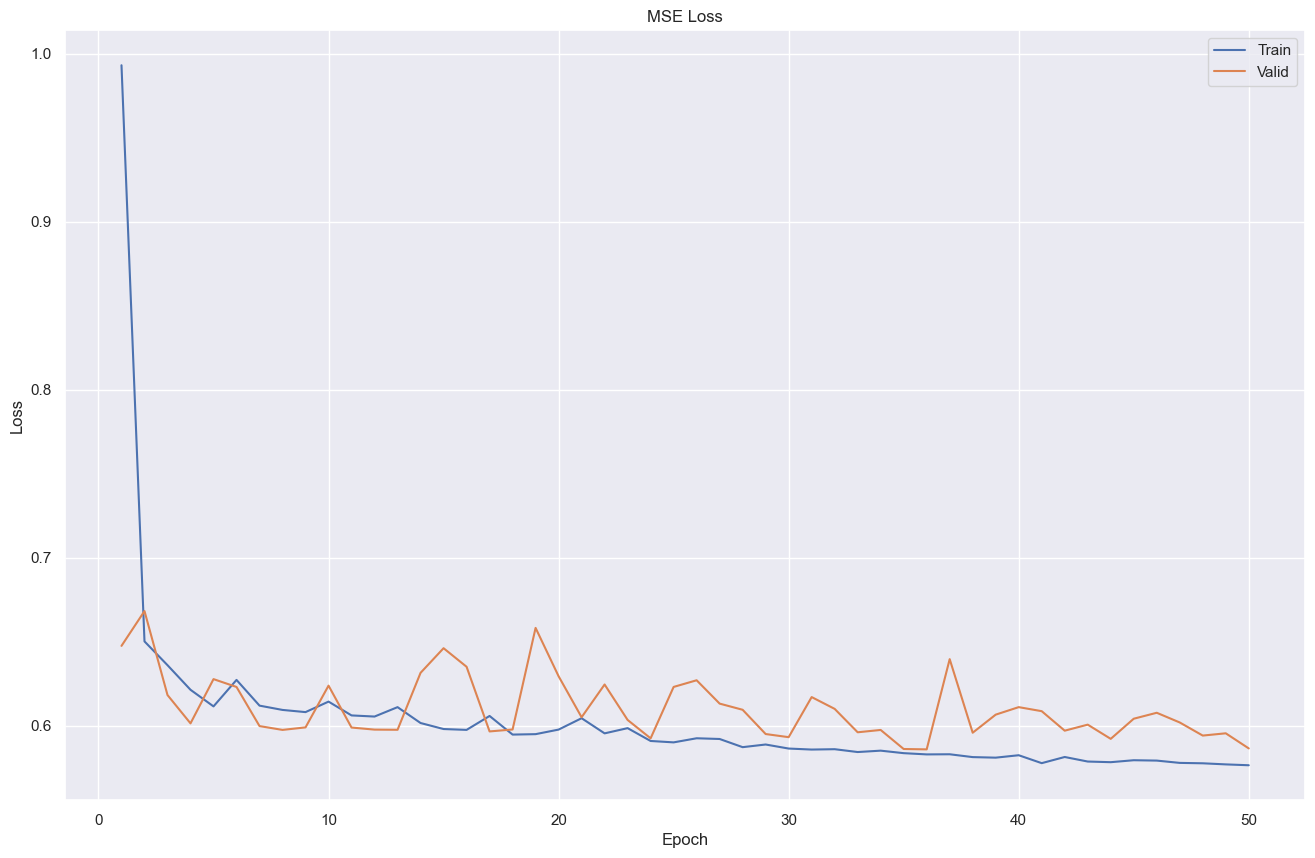

In [20]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

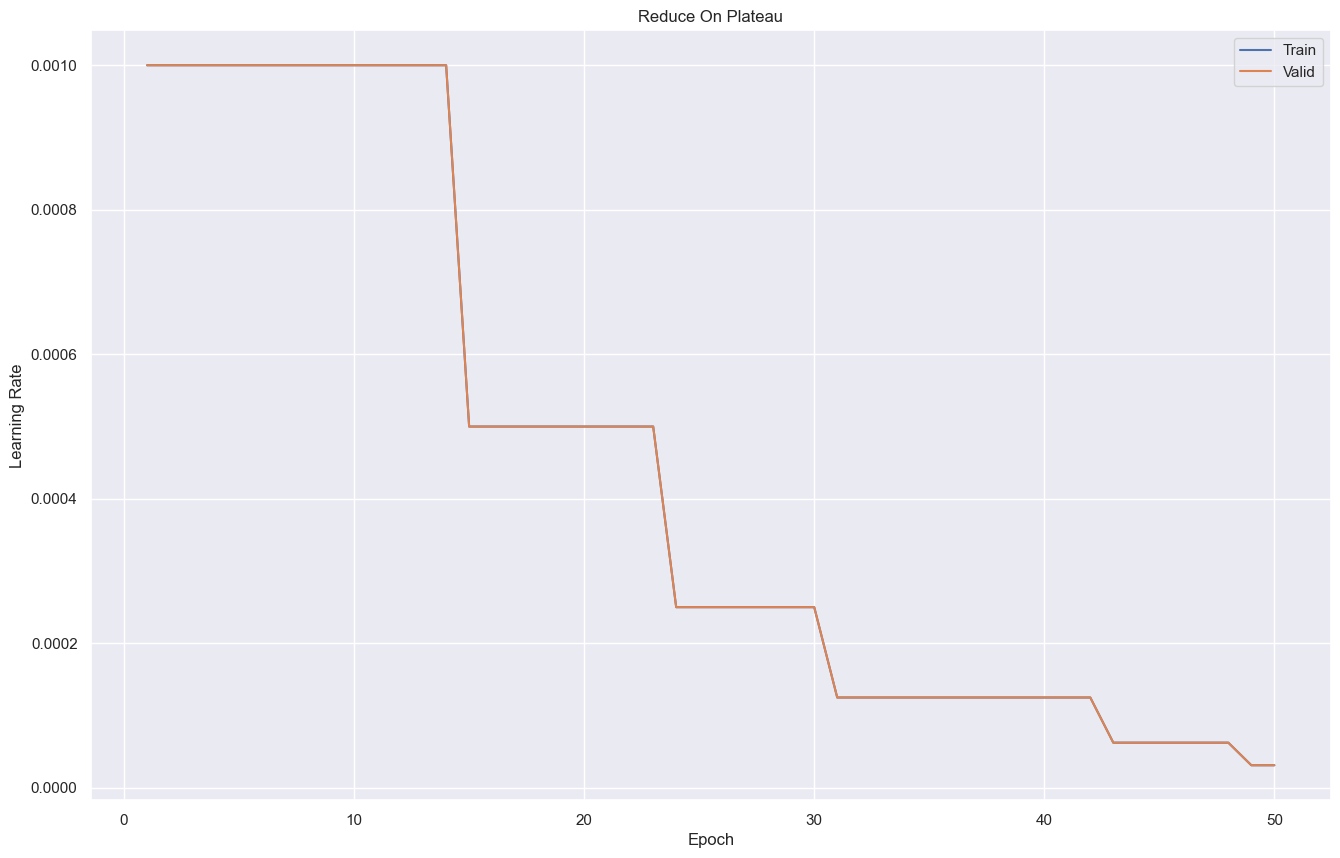

In [21]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

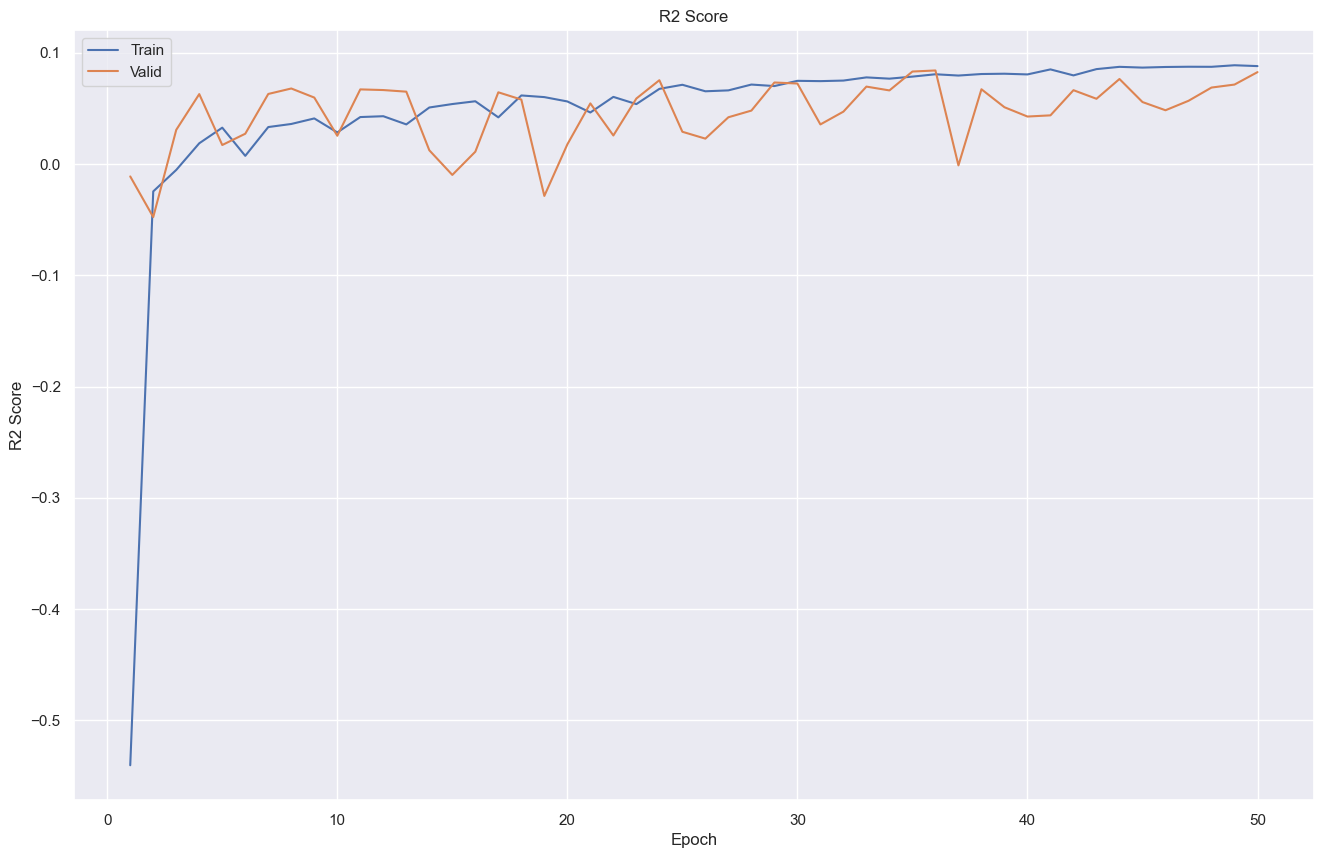

In [22]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

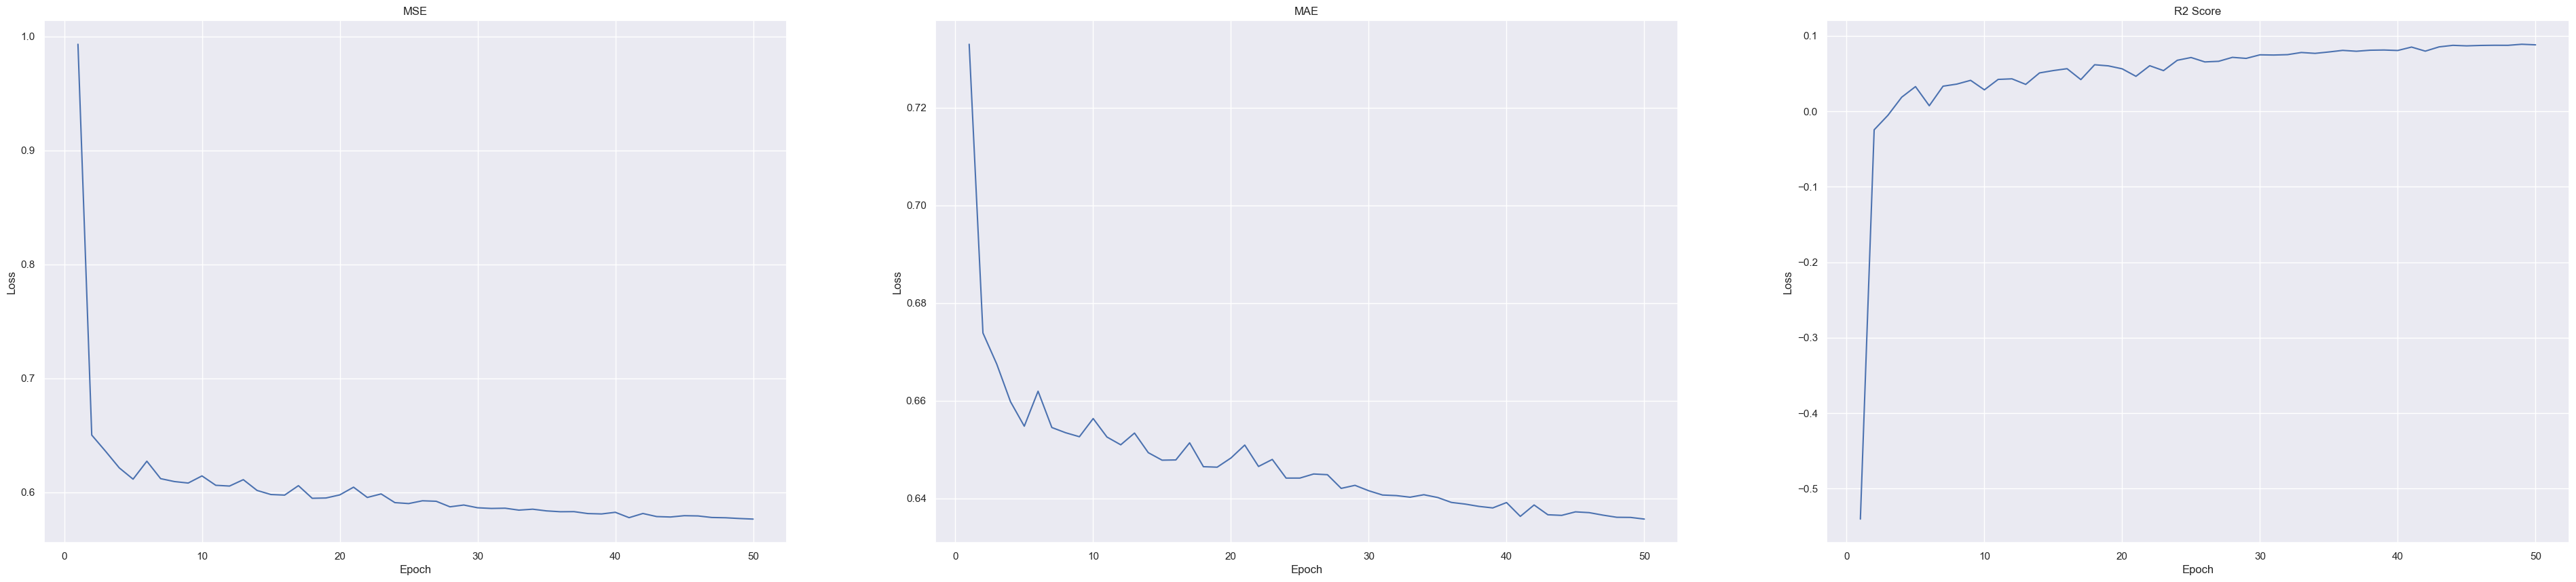

In [23]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

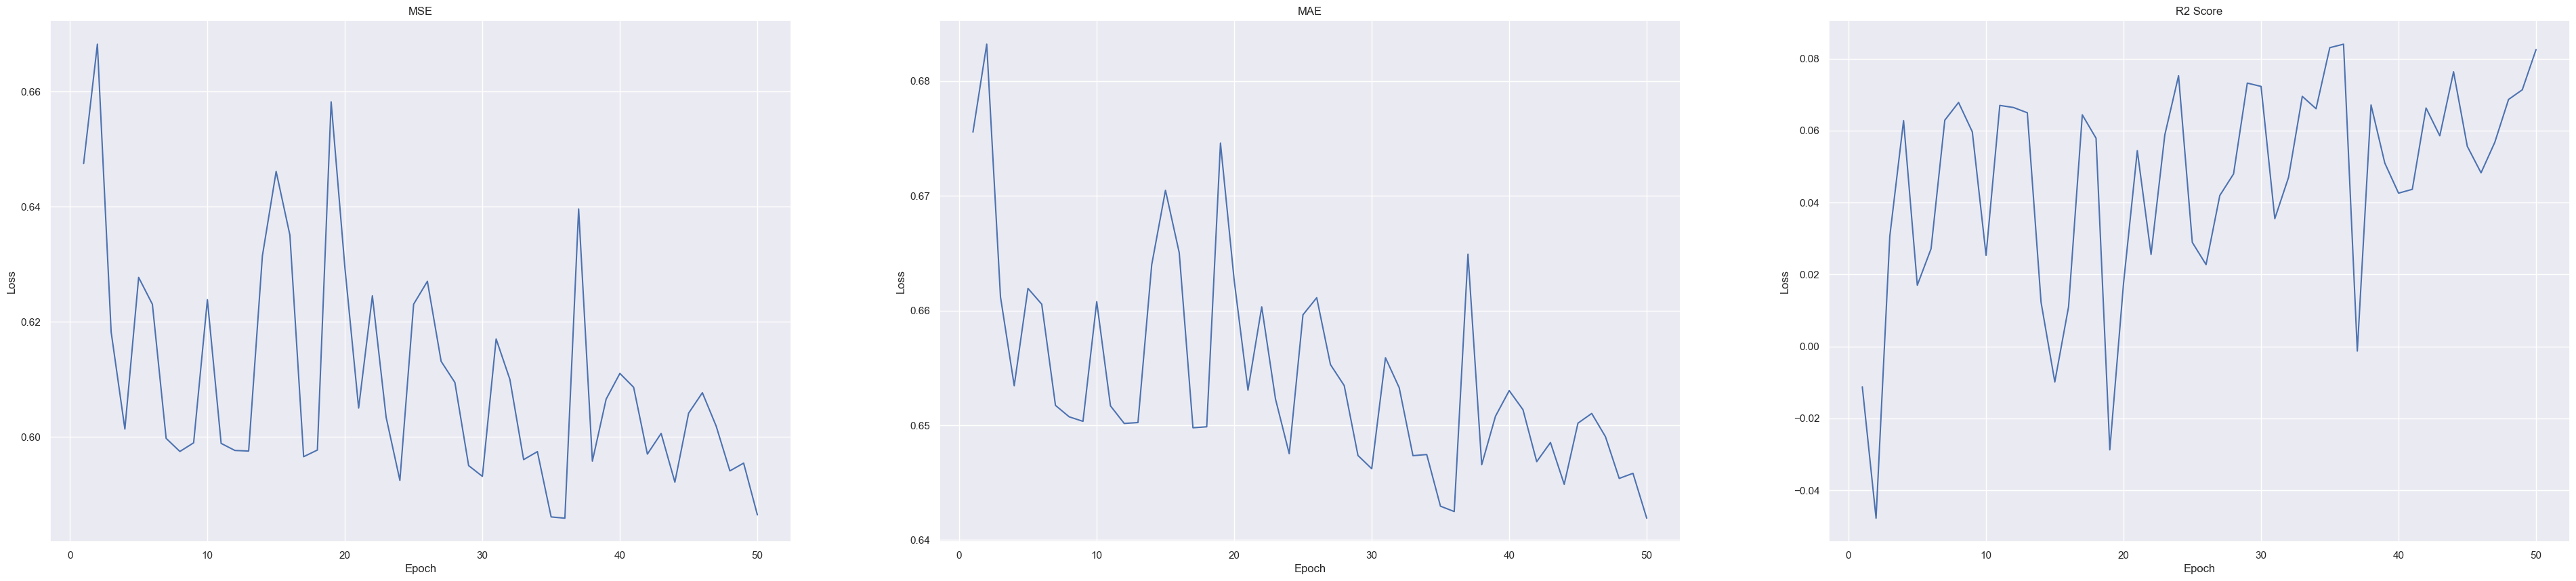

In [24]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [25]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 50
Loss  : 0.58648


<All keys matched successfully>

In [26]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.09009
MAE Loss :  0.63103
MSE Loss :  0.56500


### 5.1.2 Custom

In [27]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT1G61140.1
True : [ 1.78086    1.54861    1.82822    1.75338    1.67173]
Pred : [ 1.58048    1.26051    1.46917    1.36115    1.40885]
 MAE : [ 0.20038    0.28811    0.35905    0.39223    0.26289]
 MSE : [ 0.04015    0.08300    0.12891    0.15384    0.06911]
 R2  : [ 0.07456    0.02568    0.00331    0.03504    0.00120]

Gene : AT5G54940.2
True : [ 2.30615    2.86961    2.80670    2.76236    2.75863]
Pred : [ 1.41910    1.10900    1.28818    1.19334    1.25038]
 MAE : [ 0.88705    1.76061    1.51851    1.56902    1.50825]
 MSE : [ 0.78686    3.09974    2.30589    2.46182    2.27482]
 R2  : [-0.03391    0.12086    0.08407    0.09032    0.10737]



In [28]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report,
	order     = tpm_order,
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  37.46 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
3      seed   6080   2640    43.421    0.609    0.380
1      leaf   6080   2382    39.178    0.646    0.419
2      root   6080   2288    37.632    0.646    0.422
4  seedling   6080   2278    37.467    0.624    0.408
0    flower   6080   1801    29.622    0.630    0.412

### 5.1.3 Visualization

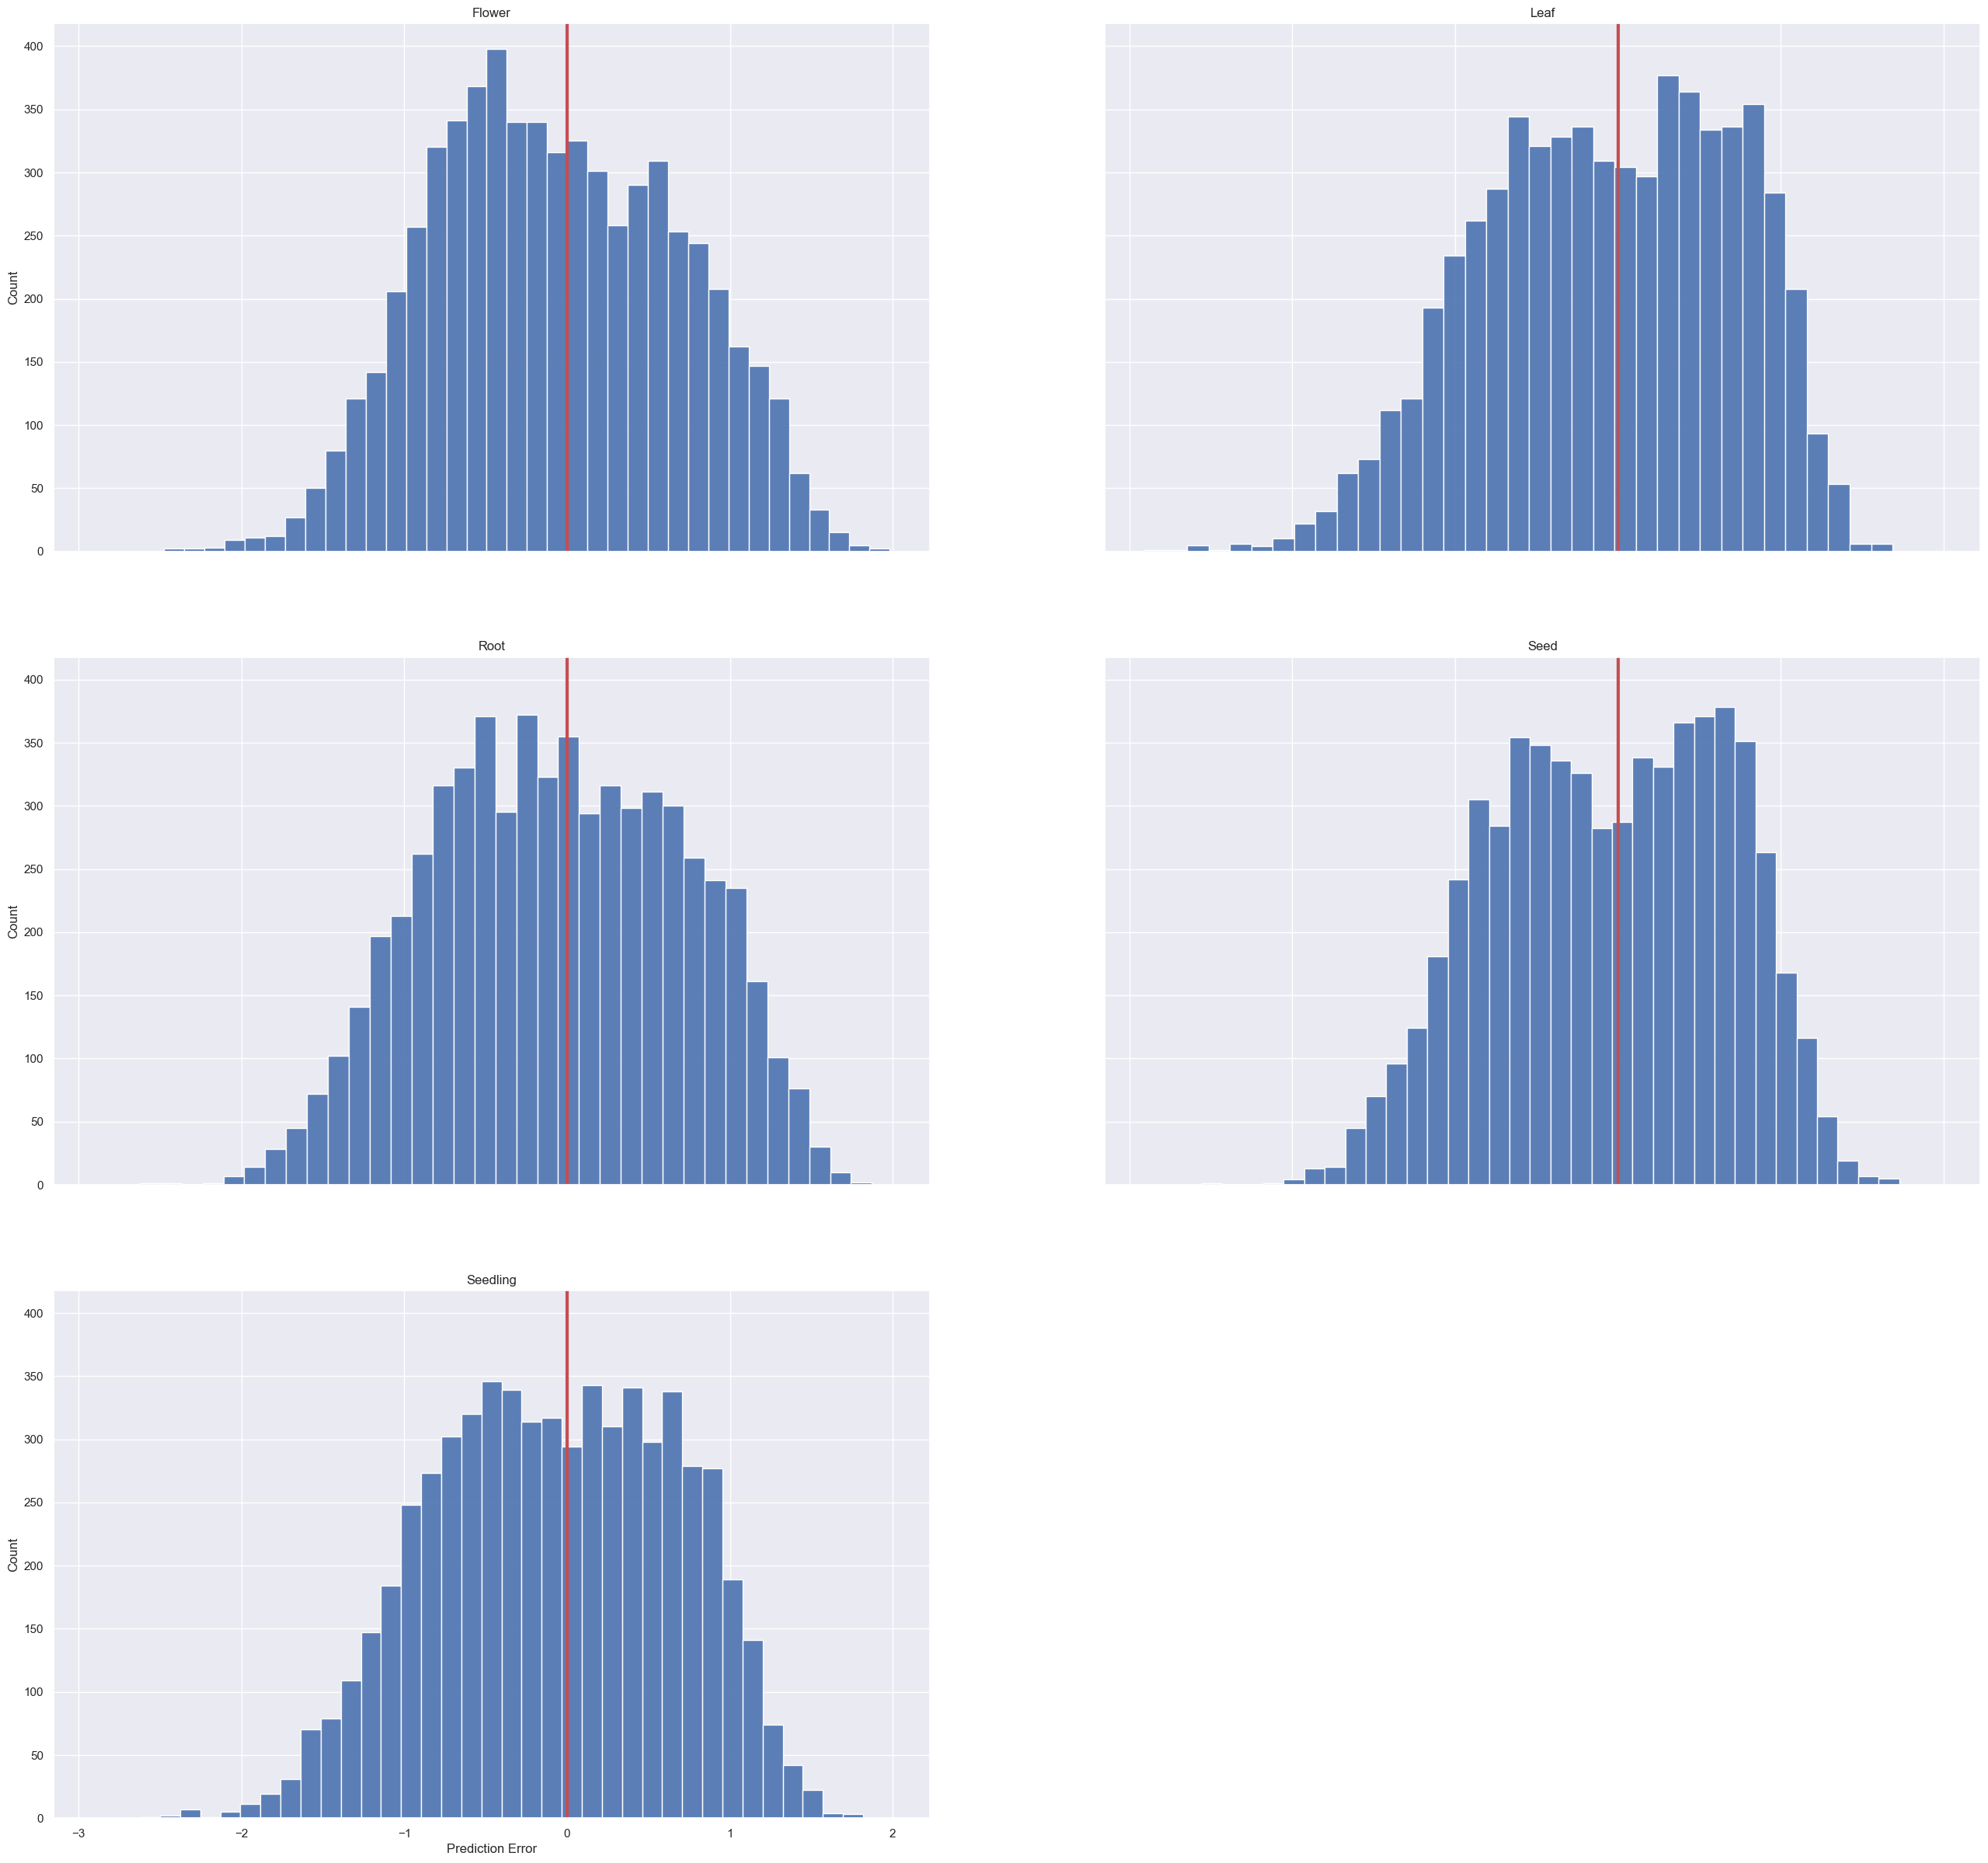

In [29]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

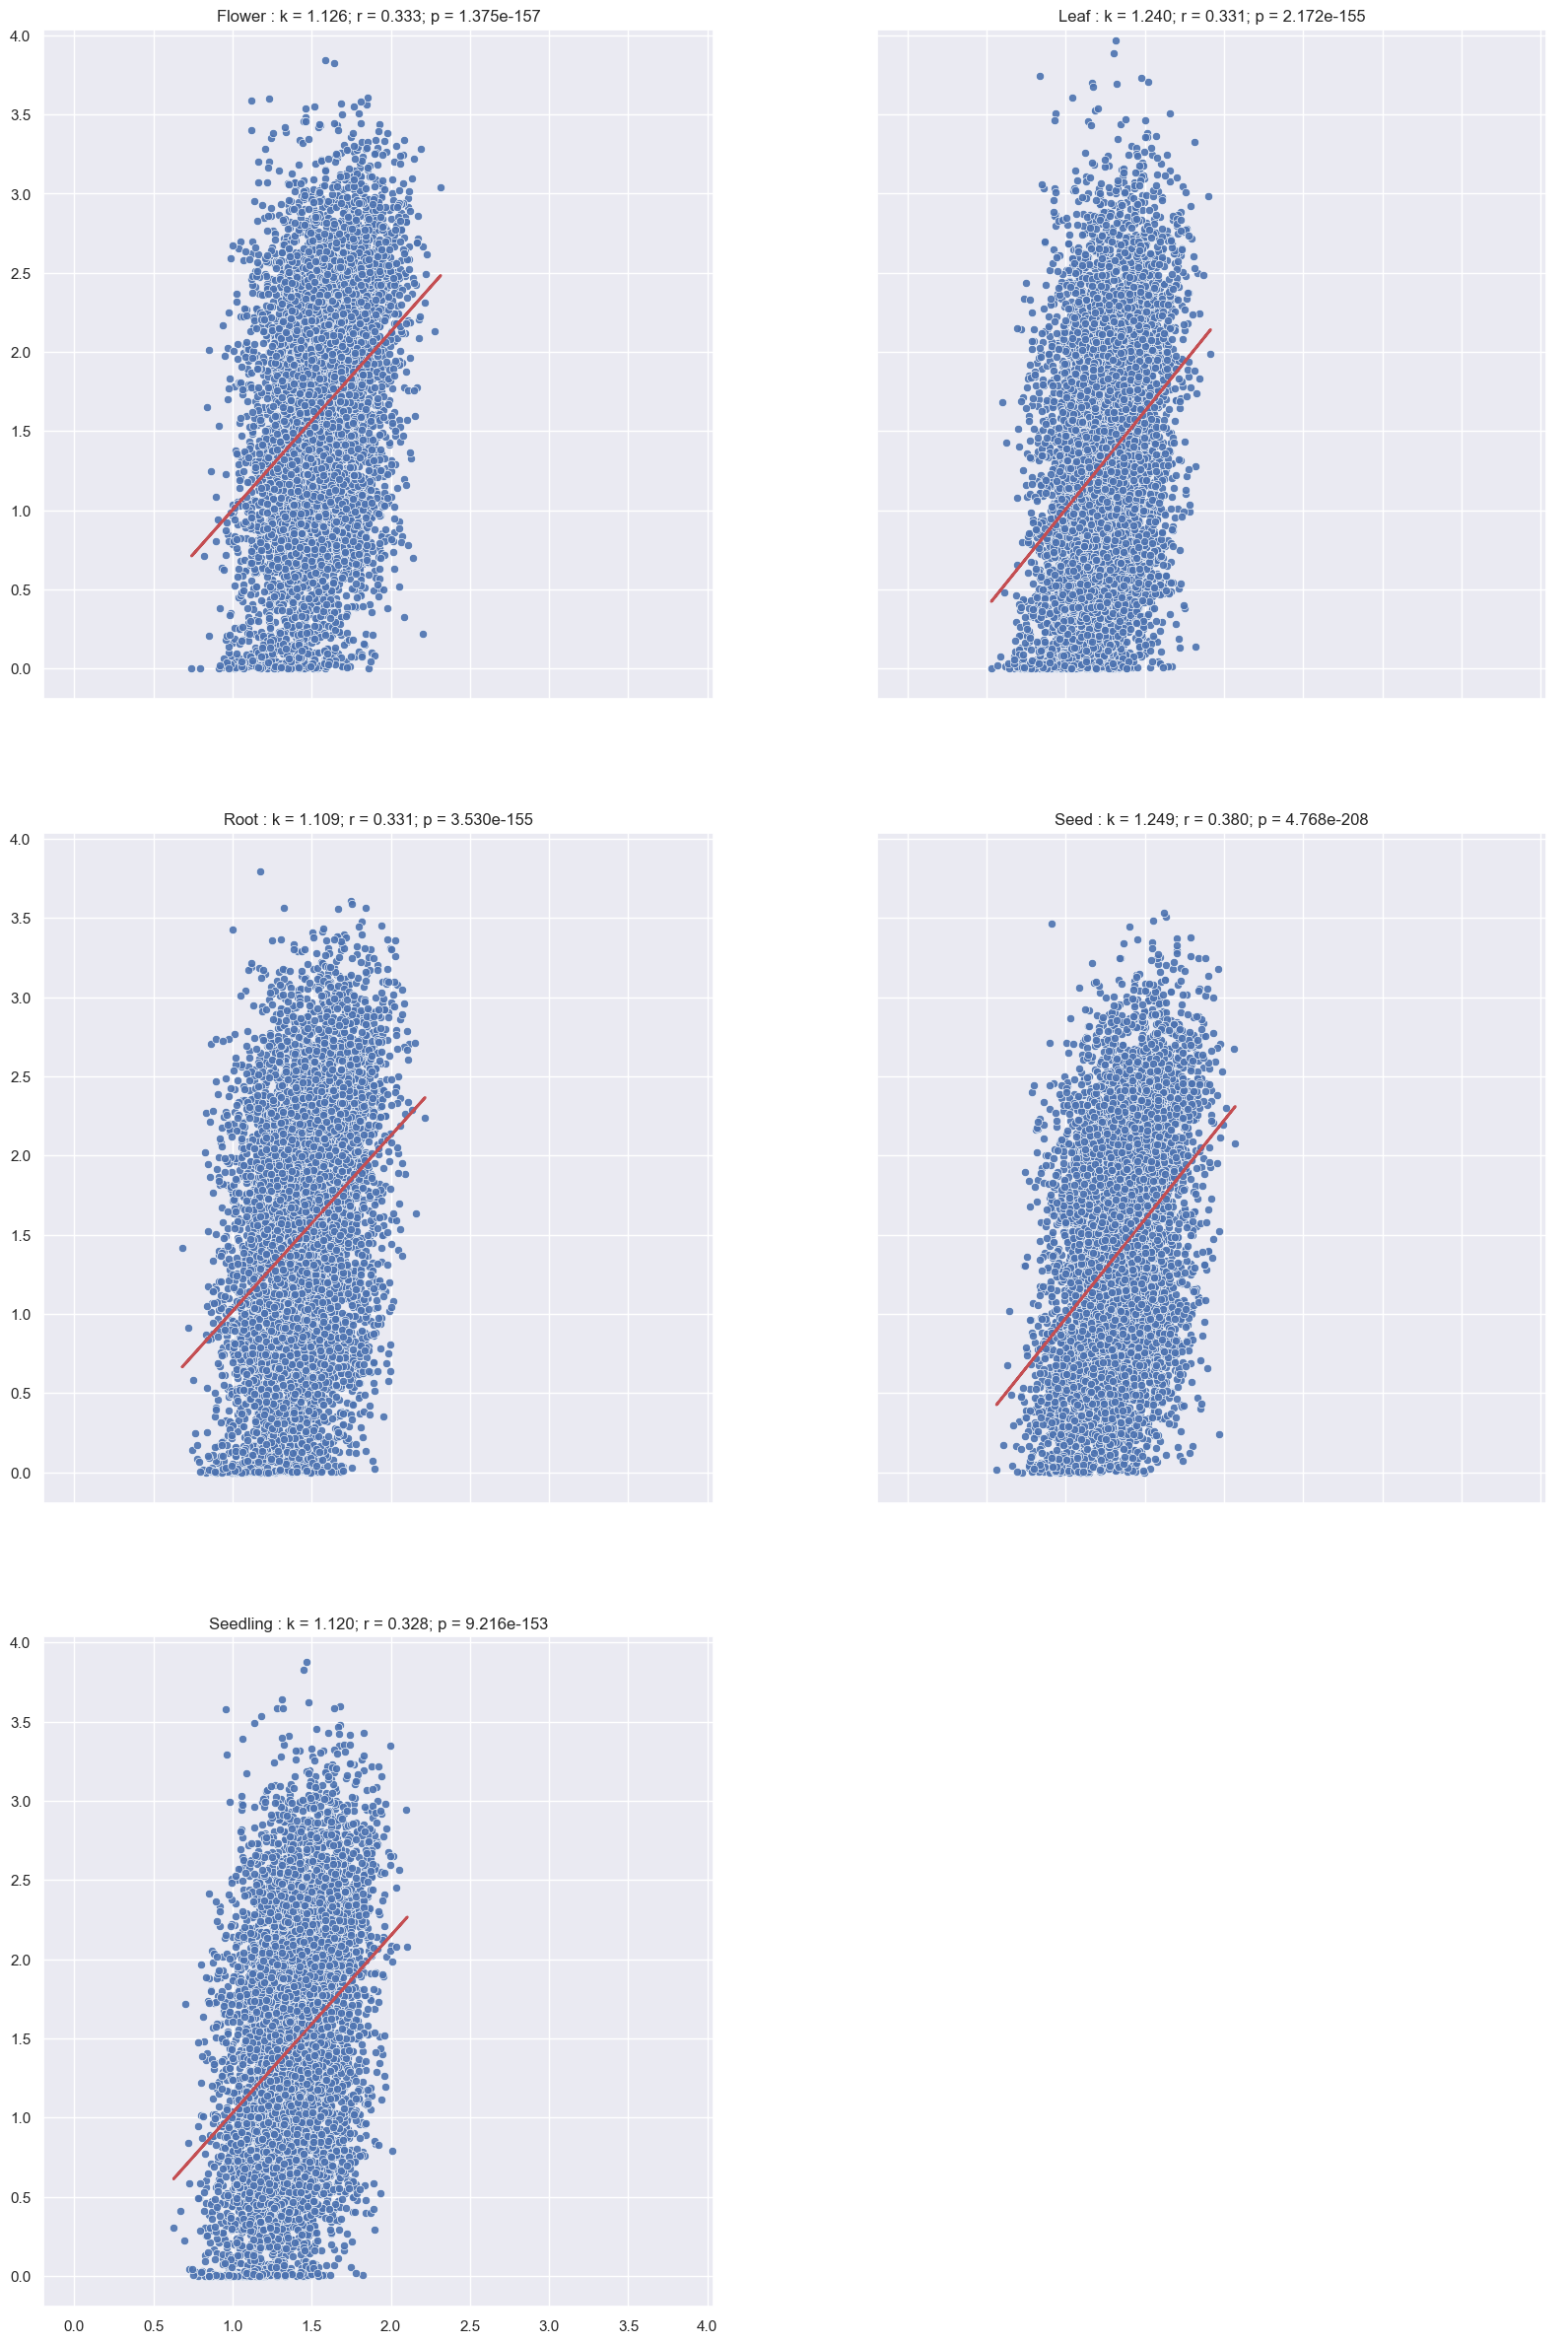

In [30]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

### 5.1.4 Mutation

In [31]:
# Evaluate the mutations

report = cnn_model.eval_regressor(
	model  = model,
	params = params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
			'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		}
	}
)

print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

MAE Loss :  0.78030
MSE Loss :  0.84614


In [32]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [33]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT3G26280.2 AT2G23740.2 AT2G16600.1 AT5G57565.2 AT5G38910.1 AT5G20400.1 AT2G19720.1 AT2G22990.3 AT3G45780.1 AT3G54480.4
 AT2G36160.1 AT3G20090.2 AT4G09980.2 AT1G50500.5 AT5G46630.1 AT1G32790.1 AT5G56540.1 AT1G11910.1 AT1G78750.1 AT5G01280.1
 AT3G59930.1 AT5G63050.2 AT1G71240.2 AT1G17640.1 AT5G67410.1


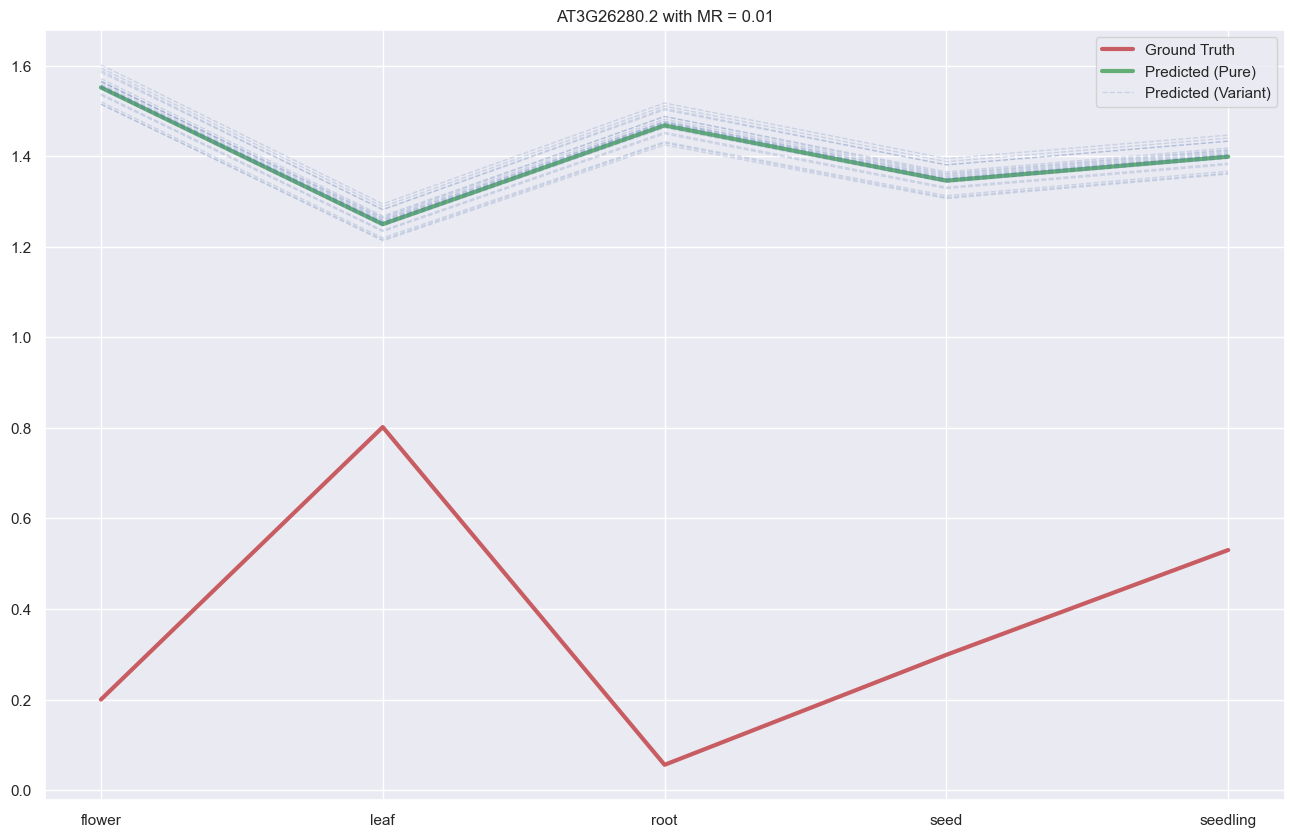

In [34]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = tpm_order
)

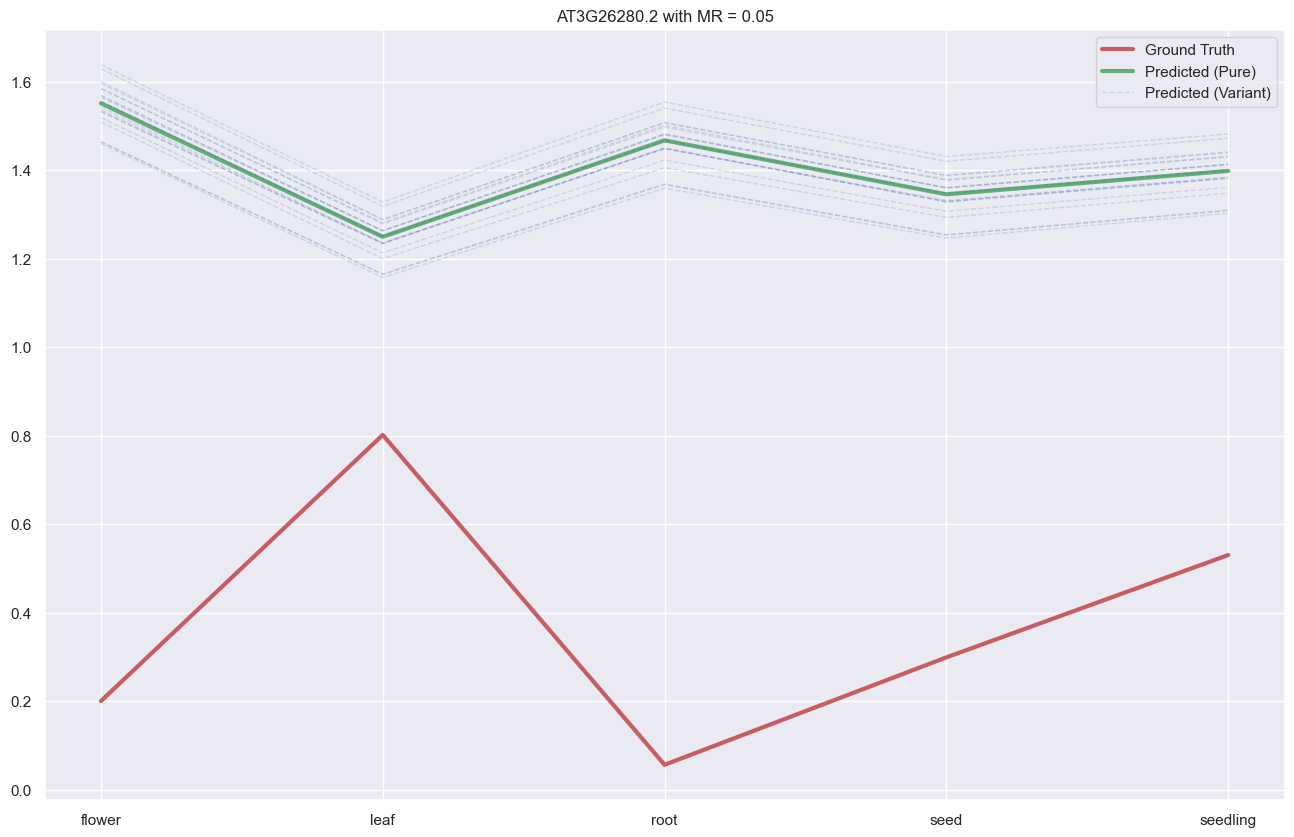

In [35]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = tpm_order
)

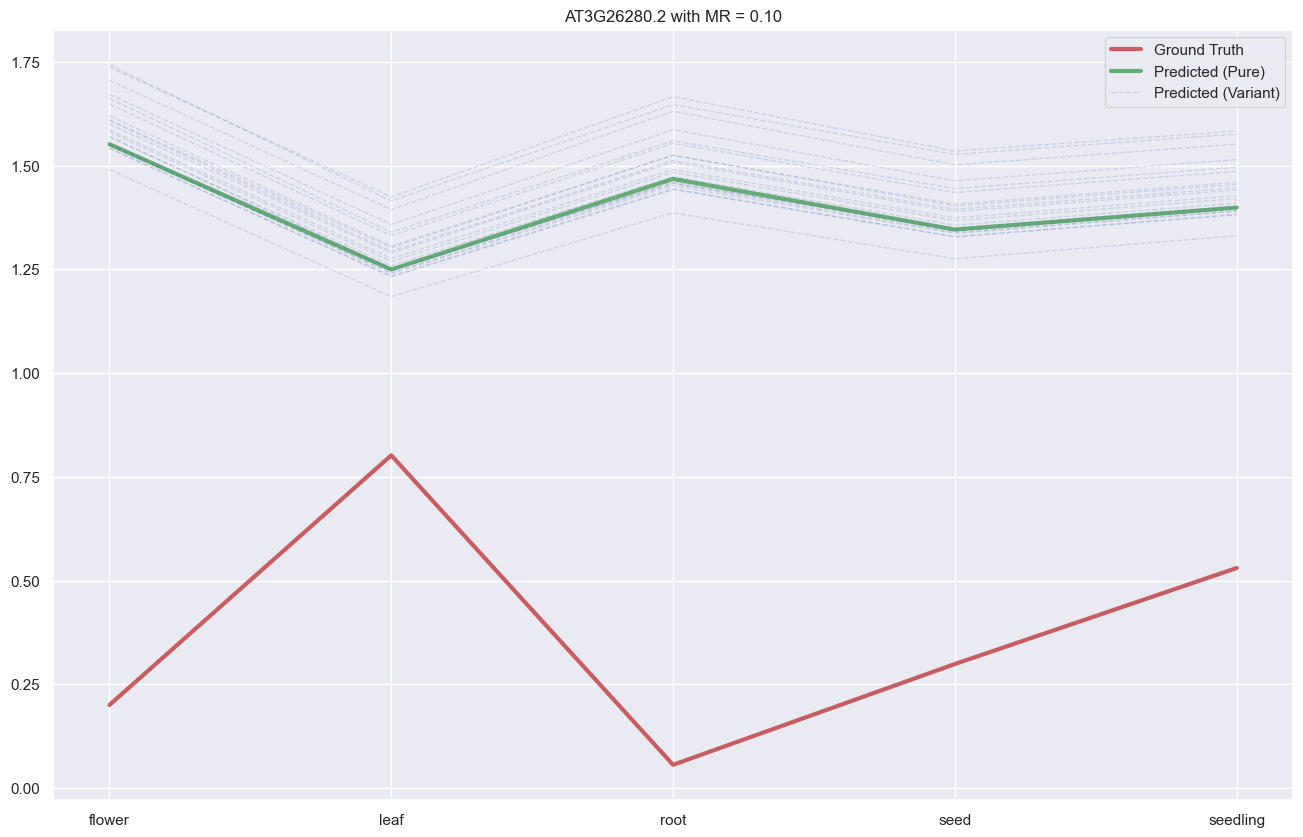

In [36]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = tpm_order
)

## 5.2 Best Model

### 5.2.1 Evaluation

In [37]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 36
 Loss : 0.58590


<All keys matched successfully>

In [38]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.09384
MAE Loss :  0.63216
MSE Loss :  0.56478


### 5.2.2 Custom

In [39]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT3G07290.1
True : [ 1.07181    0.42323    0.88517    0.87716    0.66892]
Pred : [ 1.76112    1.40648    1.61285    1.51786    1.56598]
 MAE : [ 0.68931    0.98325    0.72769    0.64070    0.89706]
 MSE : [ 0.47516    0.96678    0.52953    0.41050    0.80471]
 R2  : [ 0.17603    0.18856    0.20375    0.25410    0.20461]

Gene : AT5G56760.1
True : [ 2.71600    2.59443    3.00106    2.61275    2.72958]
Pred : [ 1.62197    1.29765    1.49874    1.39644    1.44699]
 MAE : [ 1.09403    1.29678    1.50233    1.21631    1.28259]
 MSE : [ 1.19691    1.68163    2.25699    1.47940    1.64505]
 R2  : [ 0.06979    0.07416    0.06084    0.09900    0.06269]



In [40]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report,
	order     = tpm_order,
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  37.29 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
3      seed   6080   2604    42.829    0.612    0.378
1      leaf   6080   2366    38.914    0.648    0.416
4  seedling   6080   2287    37.615    0.626    0.404
2      root   6080   2283    37.549    0.646    0.420
0    flower   6080   1796    29.539    0.629    0.412

### 5.2.3 Visualization

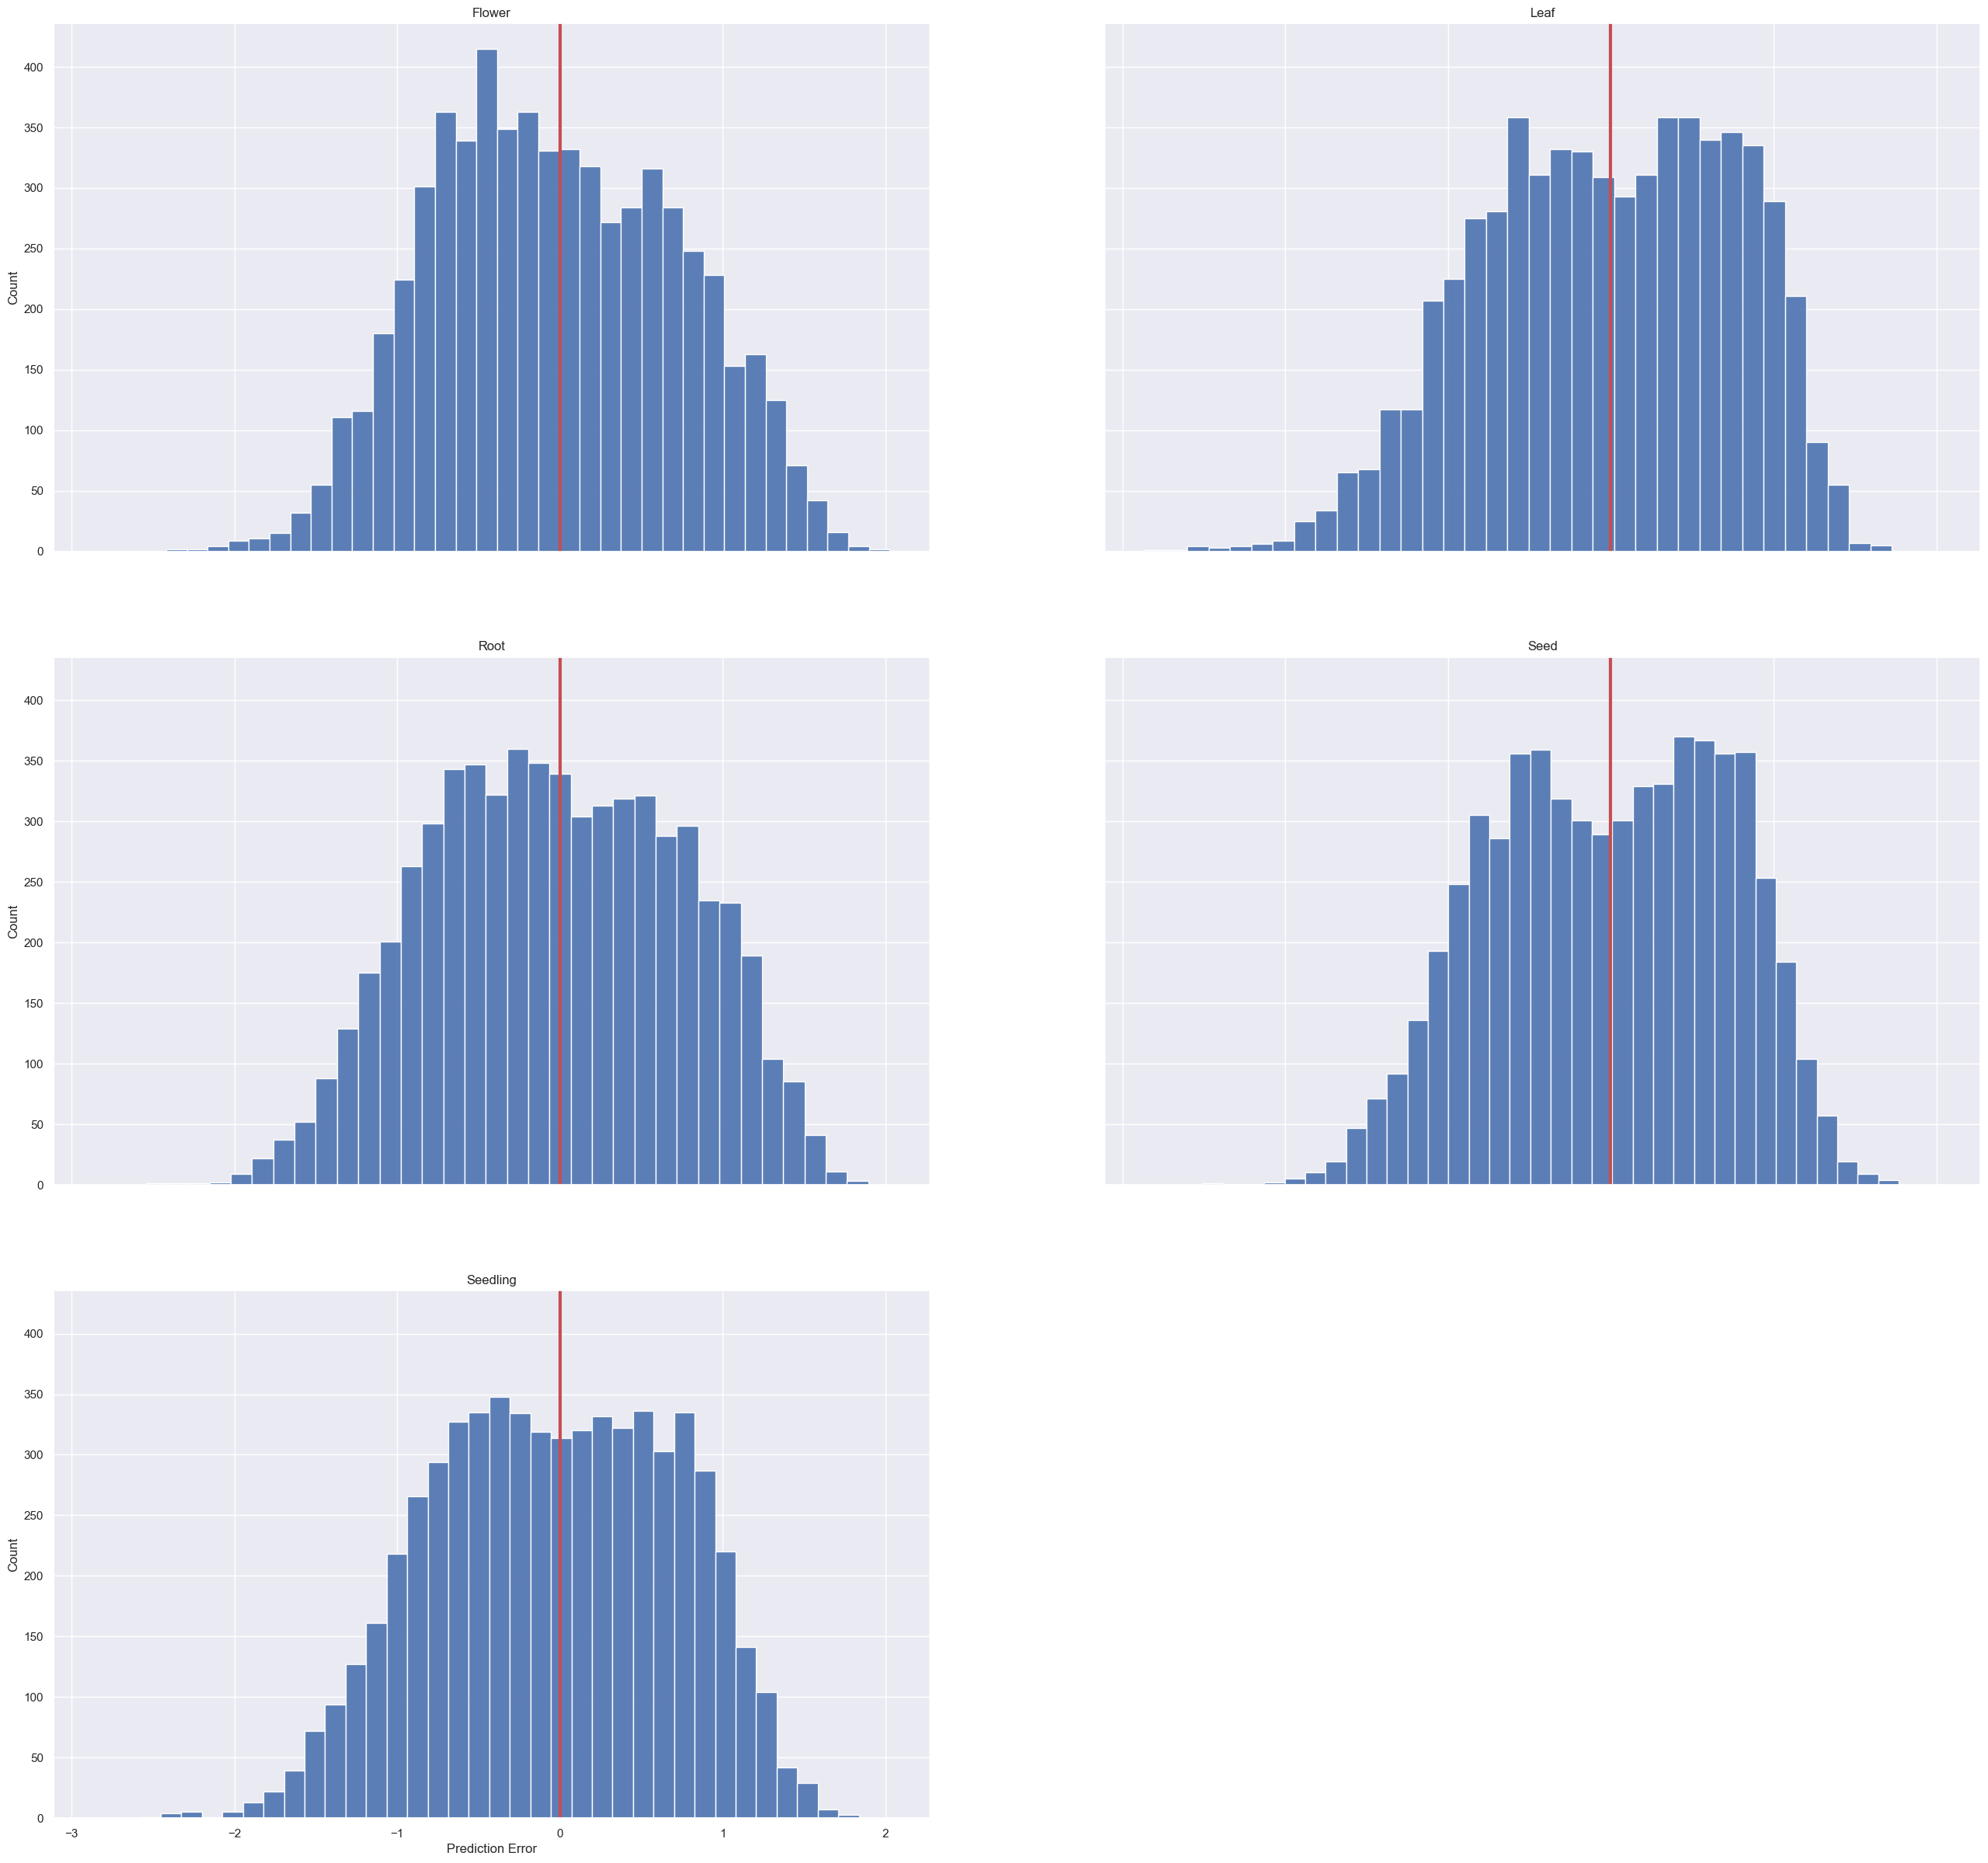

In [41]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

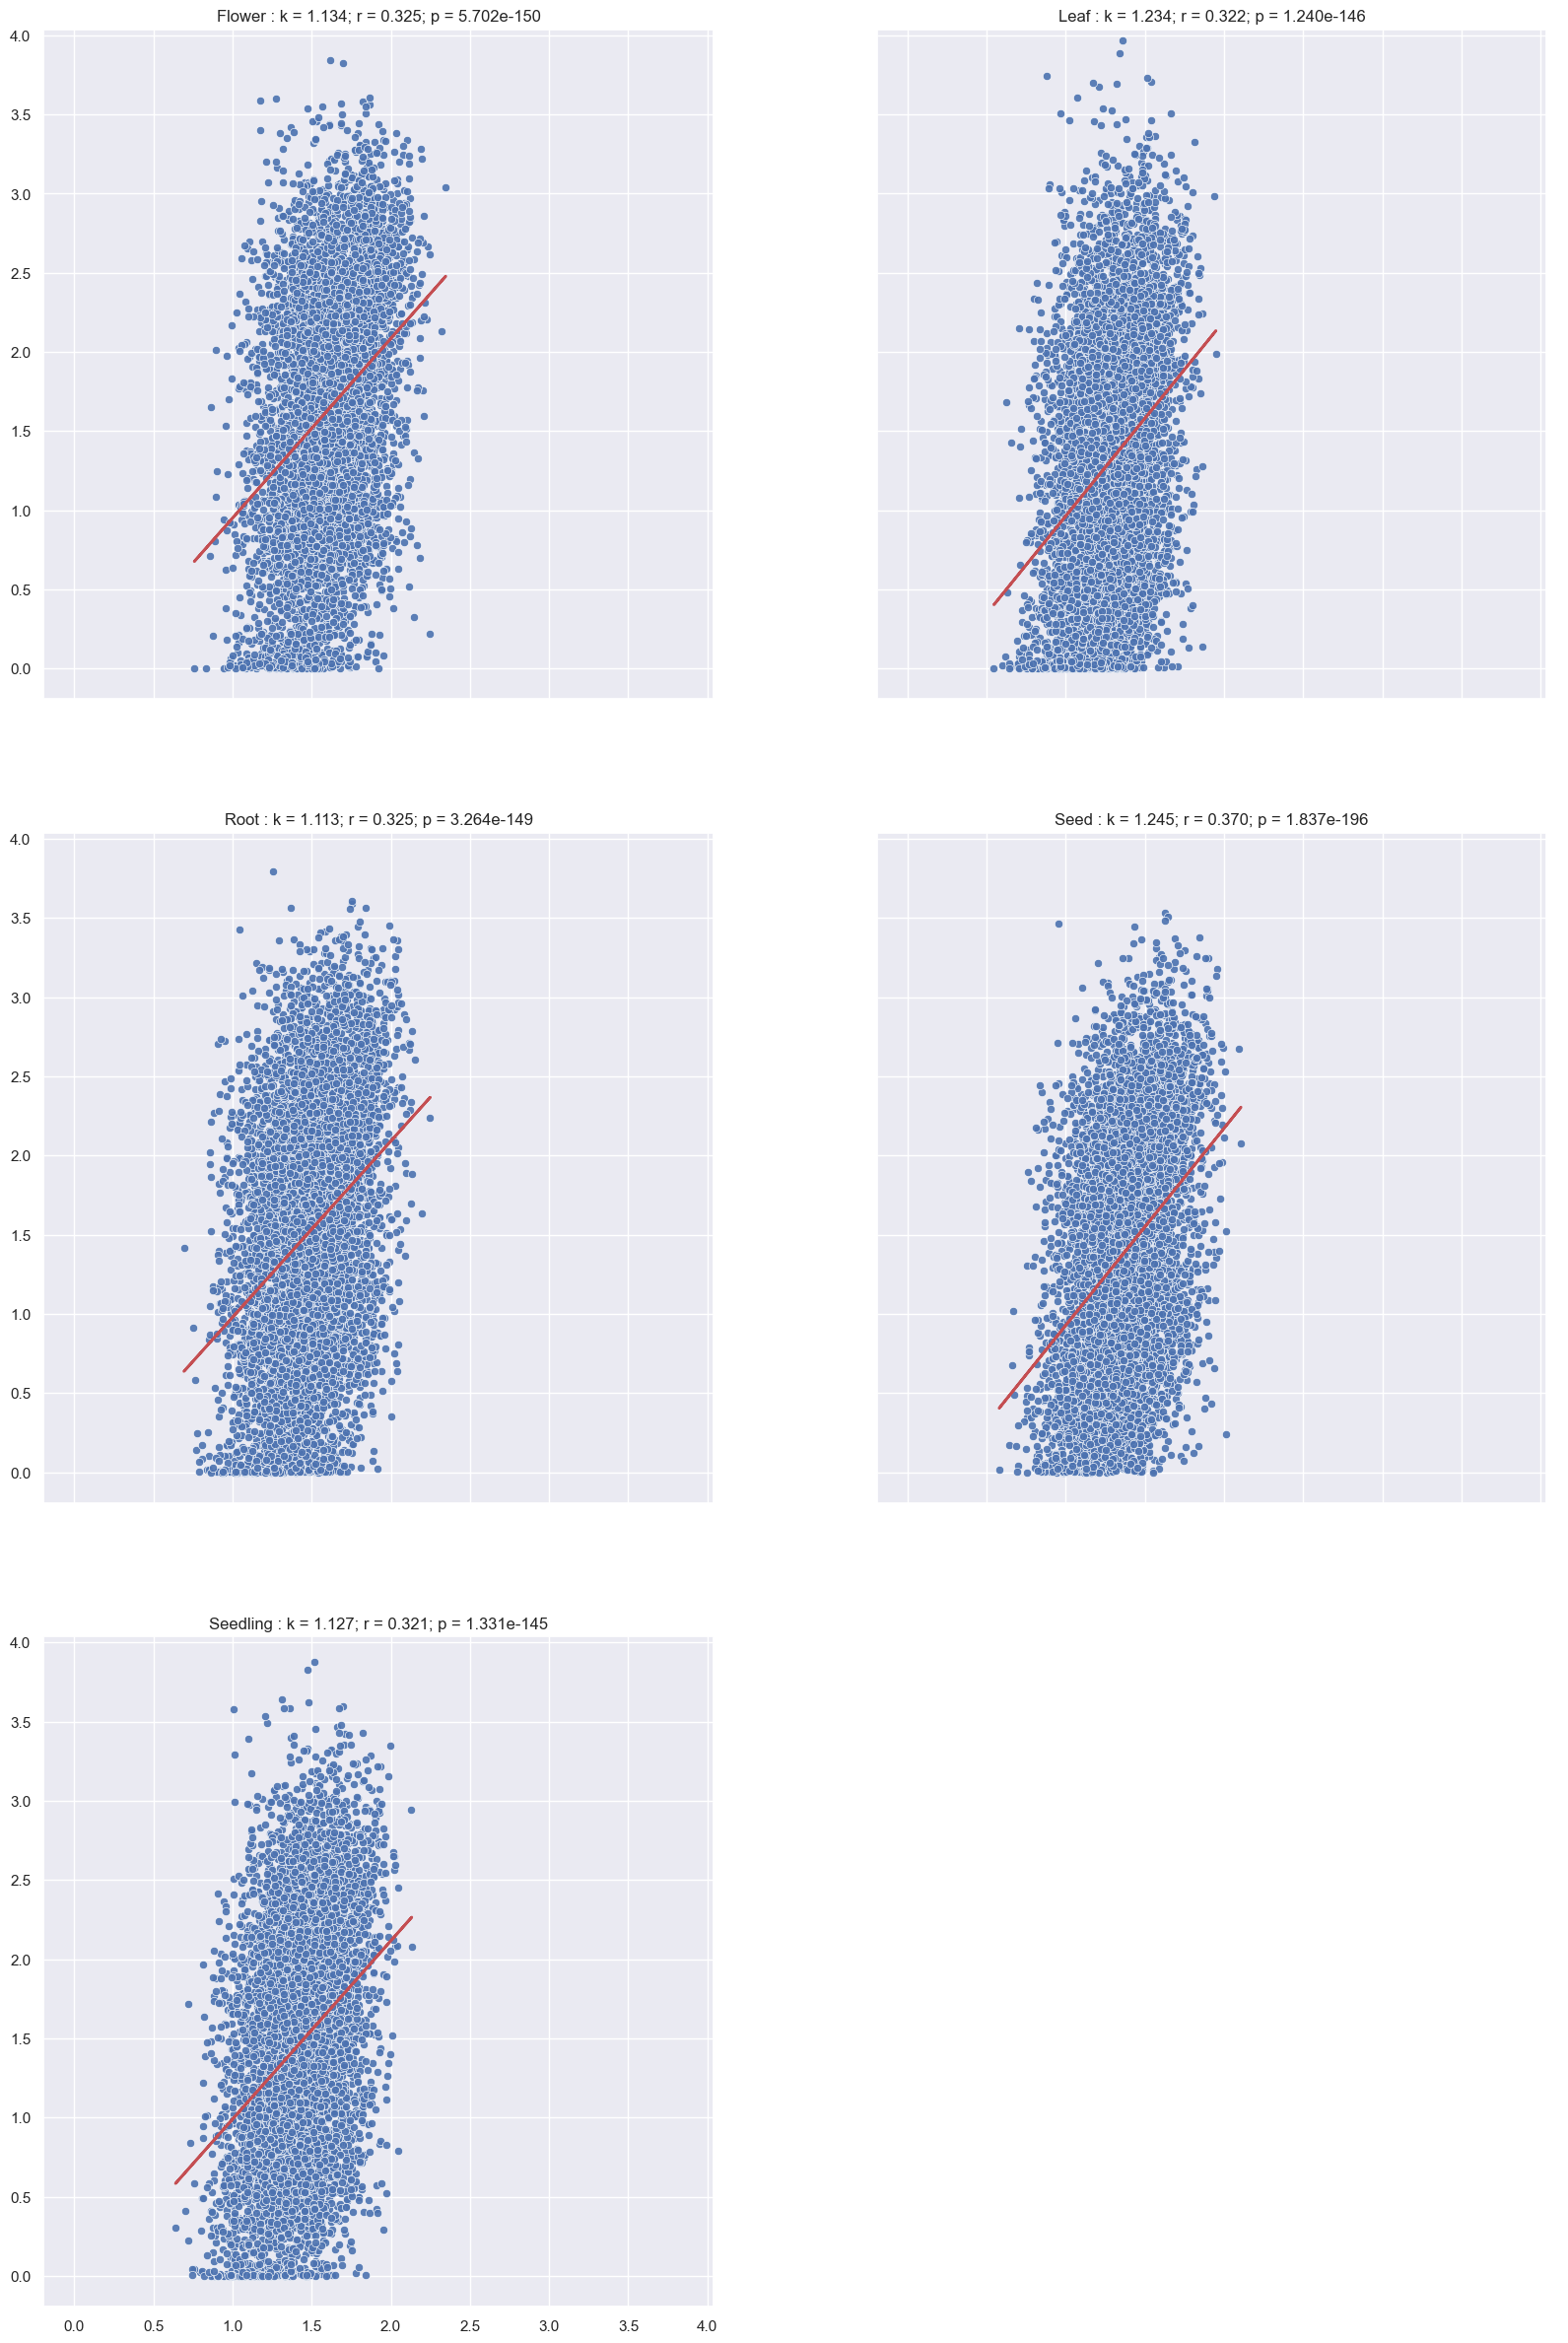

In [42]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

### 5.2.4 Mutation

In [43]:
# Evaluate the mutations

report = cnn_model.eval_regressor(
	model  = model,
	params = params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
			'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		}
	}
)

print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

MAE Loss :  0.79621
MSE Loss :  0.86240


In [44]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [45]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT3G59930.1 AT5G57565.2 AT5G46630.1 AT2G36160.1 AT1G78750.1 AT1G50500.5 AT3G26280.2 AT2G16600.1 AT3G45780.1 AT5G38910.1
 AT5G01280.1 AT1G32790.1 AT5G67410.1 AT2G23740.2 AT1G71240.2 AT2G19720.1 AT5G20400.1 AT4G09980.2 AT5G56540.1 AT3G54480.4
 AT2G22990.3 AT1G17640.1 AT3G20090.2 AT5G63050.2 AT1G11910.1


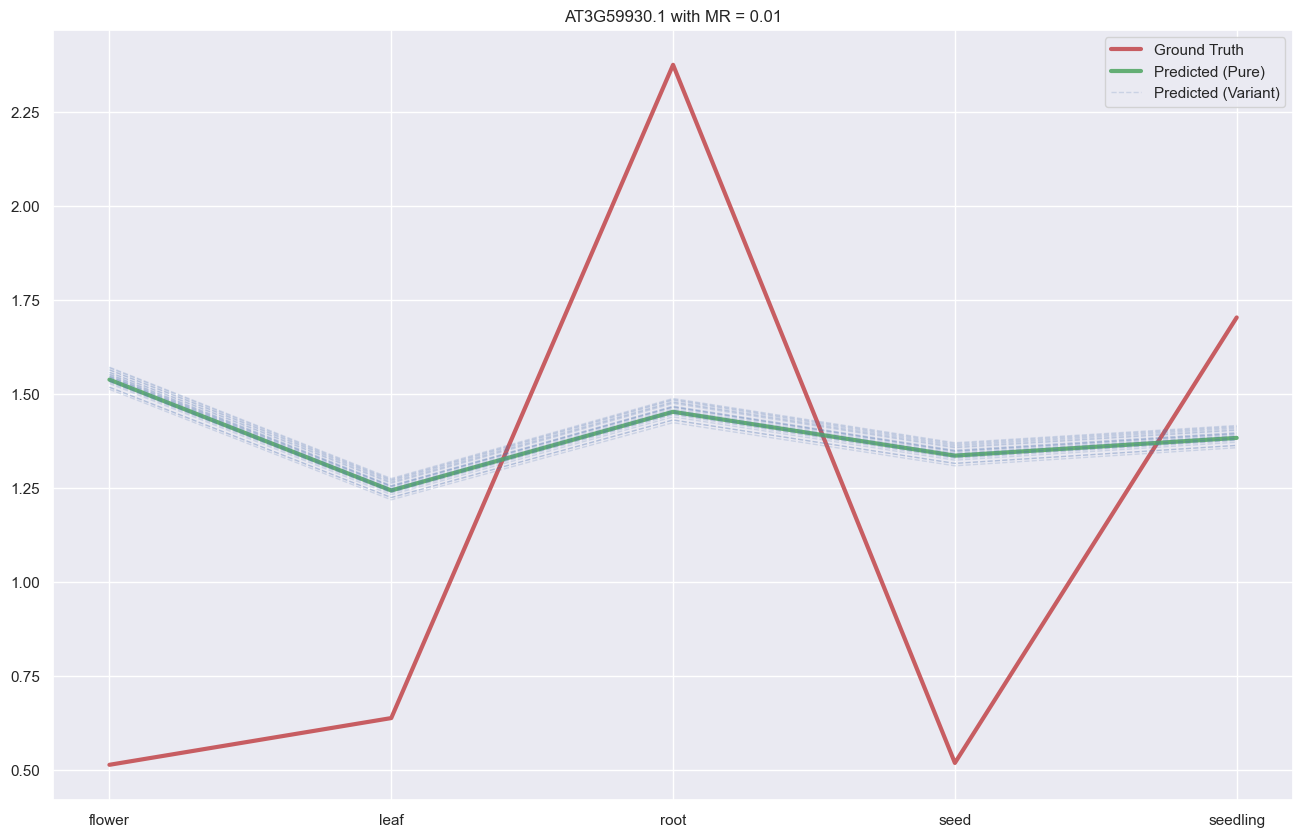

In [46]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = tpm_order
)

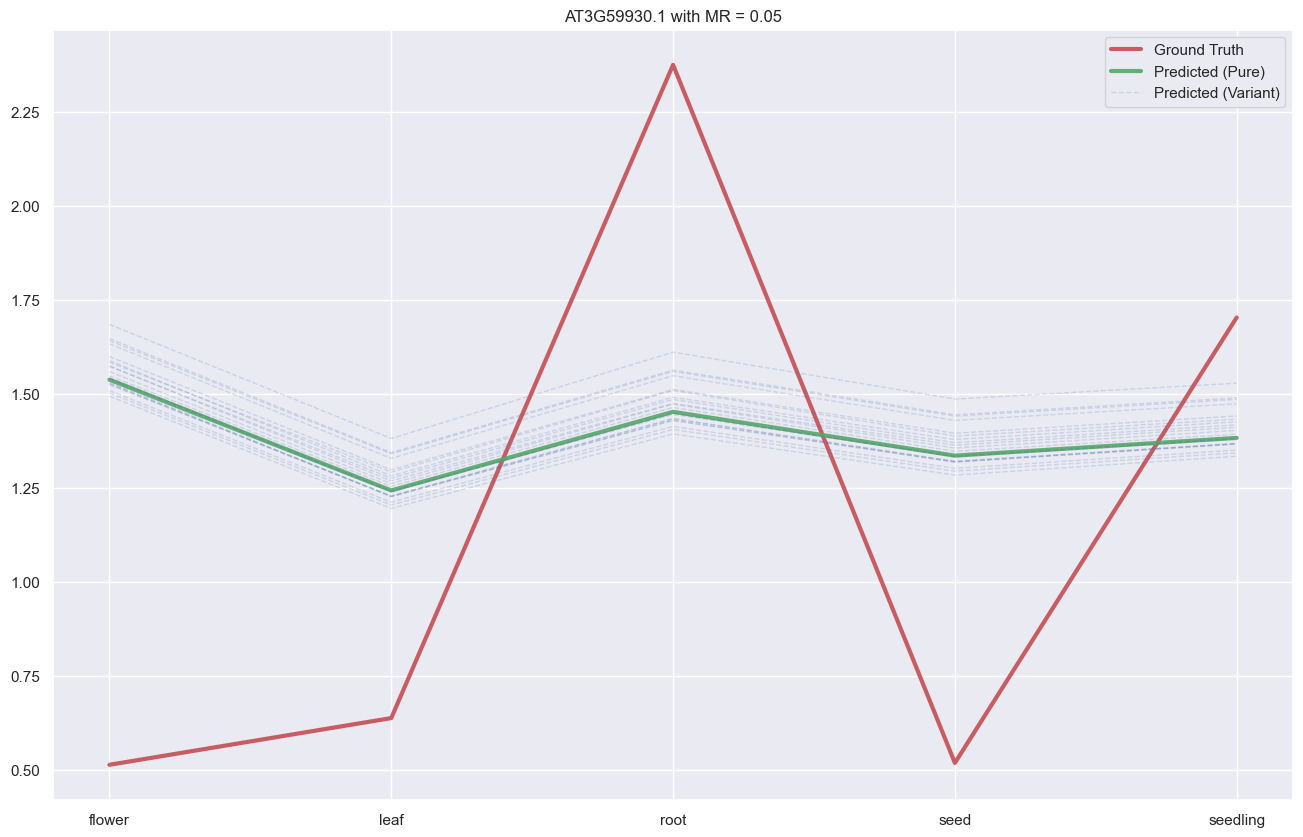

In [47]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = tpm_order
)

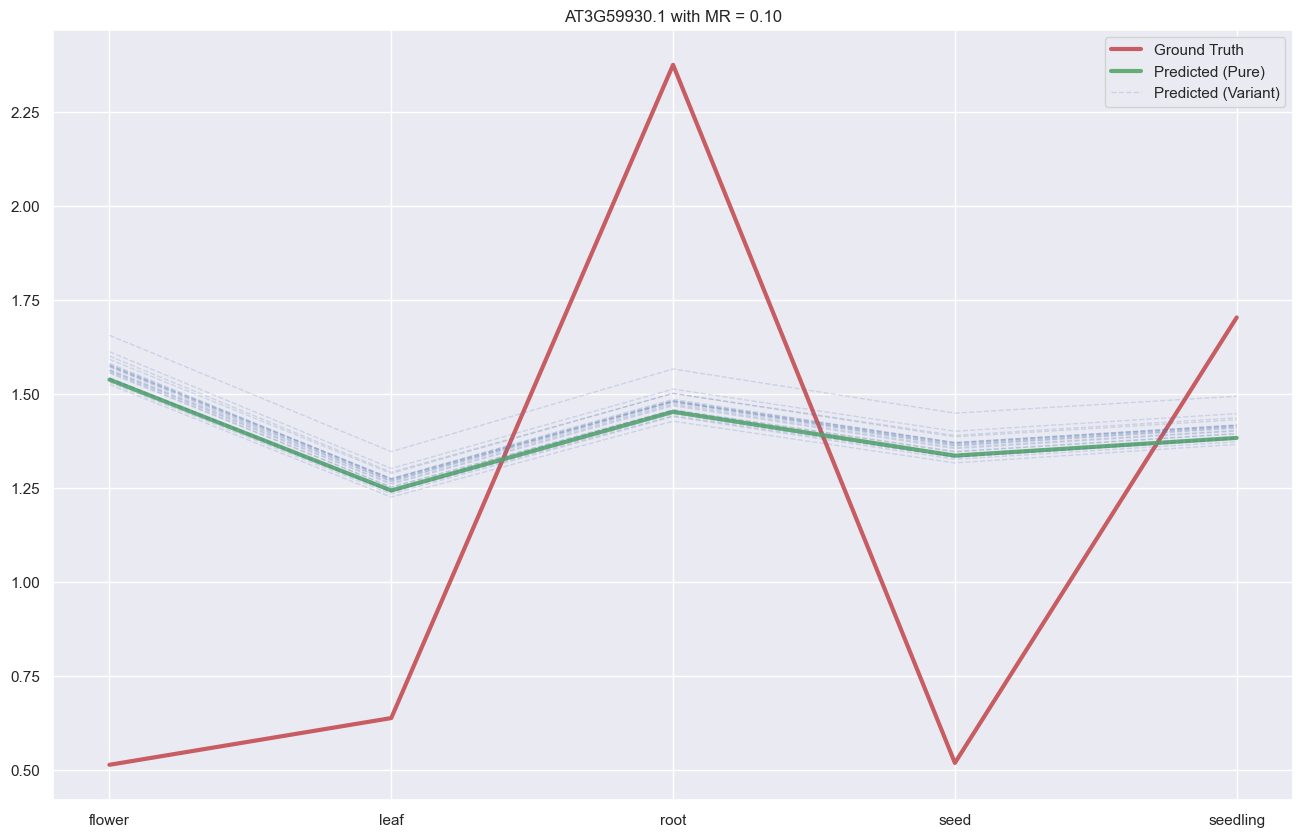

In [48]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = tpm_order
)